# Εργασία 2: Αυτόματη διάγνωση σε ιατρικές εικόνες

Πέρα από τα εργαστήρια 2a και 2b, μπορείτε να βρείτε έτοιμο σχετικό κώδικα και εδώ:

https://github.com/MedMNIST/MedMNIST/blob/main/examples/getting_started.ipynb

Εγκαθιστούμε τη βιβλιοθήκη `medmnist` στο virtual machine μας. (Χρειάζεται μόνο την πρώτη φορά κάθε session).

In [1]:
!pip install medmnist

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 87 kB 3.8 MB/s 
  Created wheel for fire: filename=fire-0.4.0-py2.py3-none-any.whl size=115942 sha256=71be7c50f84d8311e097dbb36c3d21491b54f5ea3f3bee0d55135900df03c92f
  Stored in directory: /root/.cache/pip/wheels/8a/67/fb/2e8a12fa16661b9d5af1f654bd199366799740a85c64981226
Successfully built fire


## Εισαγωγή αναγκαίων βιβλιοθηκών και πακέτων
Μπορείτε να επεκτείνετε αυτόν τον κώδικα με ό,τι χρειάζεστε

In [2]:
from tqdm import tqdm

import torch
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torch.optim import lr_scheduler
import time

import medmnist
from medmnist import INFO
from sklearn.metrics import f1_score, accuracy_score
import numpy as np
from tqdm import tqdm
import copy

print("Pytorch version:", torch.__version__)
print("GPU available:", torch.cuda.is_available())
print(f"MedMNIST v{medmnist.__version__} @ {medmnist.HOMEPAGE}")

Pytorch version: 1.11.0+cu113
GPU available: True
MedMNIST v2.1.0 @ https://github.com/MedMNIST/MedMNIST/


## Transforms
Θα χρησιμοποιήσουμε τις ίδιες προεπεξεργασίες για όλα τα δεδομένα μας ώστε τα διαφορετικά μοντέλα να είναι συμβατά μεταξύ τους.

Αυτό στηρίζεται στο ότι οι εικόνες των datasets που θα χρησιμοποιήσουμε θα έχουν ίσες διαστάσεις μεταξύ τους (28$\times$28$\times$3)

In [3]:
data_transforms = {
    'train': transforms.Compose([
        transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),transforms.RandomHorizontalFlip()
    ]),
    'test': transforms.Compose([
        transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]),
}

## Εισαγωγή του Colon Pathology dataset 

In [4]:
# Το αντικείμενο medmnist.INFO μανατζάρει όλα τα datasets του medmnist. Με το κλειδί 'pathmnist' (το βρήκαμε στο documentation) επιλέγουμε το Colon Pathology Dataset
path_info = INFO['pathmnist']
path_task = path_info['task']
path_channels = path_info['n_channels']
path_classes = len(path_info['label'])

print ("Οι εικόνες του dataset έχoυν", path_channels, "κανάλια. Ο τύπος προβλήματος είναι", path_task, "ταξινόμηση με", path_classes, "κλάσεις.")

Οι εικόνες του dataset έχoυν 3 κανάλια. Ο τύπος προβλήματος είναι multi-class ταξινόμηση με 9 κλάσεις.


  0%|          | 0/205615438 [00:00<?, ?it/s]

Using downloaded and verified file: /root/.medmnist/pathmnist.npz
Using downloaded and verified file: /root/.medmnist/pathmnist.npz
---------------------------------------------------------------------
Διαθέσιμες πληροφορίες για το dataset:
dict_keys(['python_class', 'description', 'url', 'MD5', 'task', 'label', 'n_channels', 'n_samples', 'license'])
Περιγραφή dataset:
The PathMNIST is based on a prior study for predicting survival from colorectal cancer histology slides, providing a dataset (NCT-CRC-HE-100K) of 100,000 non-overlapping image patches from hematoxylin & eosin stained histological images, and a test dataset (CRC-VAL-HE-7K) of 7,180 image patches from a different clinical center. The dataset is comprised of 9 types of tissues, resulting in a multi-class classification task. We resize the source images of 3×224×224 into 3×28×28, and split NCT-CRC-HE-100K into training and validation set with a ratio of 9:1. The CRC-VAL-HE-7K is treated as the test set.
Ερμηνεία labels:
{'0'

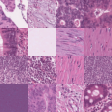

In [5]:
# Το πεδίο 'python_class' του info επιστρέφει μια κλάση της python που λειτουργεί ως pytorch dataset, για να την περάσουμε στο dataloader
Path_DataClass = getattr(medmnist, path_info['python_class'])

# Φόρτωση (και κατέβασμα) δεδομένων
path_train_dataset = Path_DataClass(split='train', transform=data_transforms['train'], download=True)
path_val_dataset = Path_DataClass(split='val', transform=data_transforms['test'], download=True)
path_test_dataset = Path_DataClass(split='test', transform=data_transforms['test'], download=True)

#Το .info είναι ένα dictionary με επεξηγηματικές πληροφορίες για το dataset
print("---------------------------------------------------------------------")
print("Διαθέσιμες πληροφορίες για το dataset:")
print(path_train_dataset.info.keys())
print("Περιγραφή dataset:")
print(path_train_dataset.info['description'])
print("Ερμηνεία labels:")
print(path_train_dataset.info['label'])

#Το αλλάζουμε σύμφωνα με την εκφώνηση
BATCH_SIZE = 128

# encapsulate data into dataloader form
#Στον αρχικό κώδικα το path_test_loader έπαιρνε τιμές απο το validation dataset οπότε το άλλαξα να παίρνει τιμές απο το test dataset.
path_train_loader = data.DataLoader(dataset=path_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
path_val_loader = data.DataLoader(dataset=path_val_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
path_test_loader = data.DataLoader(dataset=path_test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

print("Δείγμα εικόνων του Colon Pathology dataset:")
path_train_dataset.montage(length=4)

## Δημιουργία μοντέλου

Ο ενδεικτικός κώδικας του MedMNIST προβλέπει τόσο ο αριθμός των καναλιών των εικόνων όσο και ο αριθμός των κλάσεων να εισάγονται ως παράμετροι. Αυτή η ευελιξία δεν μας είναι απαραίτητη καθώς εμείς θα δημιουργήσουμε ένα δίκτυο που θα δέχεται εικόνες 3 καναλιών και θα επιστρέφει 9 κλάσεις, συγκεκριμένα για το PathMNIST. Οποιαδήποτε αλλαγή κάνουμε (π.χ. στον αριθμό των κλάσεων/μονάδων εξόδου) θα γίνει αφού δημιουργήσουμε ένα στιγμιότυπο του ίδιου δικτύου.

Παρόλα αυτά, αν προτιμάτε να τα αφήσετε ως παραμέτρους, μπορείτε.

In [6]:
print("Λοιπός κώδικας παραμετροποίησης, training, testing κλπ εδώ")

Λοιπός κώδικας παραμετροποίησης, training, testing κλπ εδώ


In [7]:
#Δομή μοντέλου
class Net(nn.Module):
  def __init__(self, in_channels, num_classes):
        super(Net, self).__init__()
        

        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels, 16, kernel_size=3,padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU())

        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3,padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU())

        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5,padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.layer4 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.layer5 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.fc = nn.Sequential(
            
            nn.Linear(576, 1024),
            nn.Linear(1024, num_classes))

  def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)    
        x = self.layer5(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

print("Κανάλια:",path_channels,"Κλάσεις:",path_classes)
model = Net(in_channels=path_channels, num_classes=path_classes)

#Πιο πάνω είδαμε πως το cuda είναι available.Δημιουργούμε ένα νέο instance του δικτυού που αξιοποιεί την gpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)


Κανάλια: 3 Κλάσεις: 9


In [8]:
learning_rate = 0.005
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
#Μειώνουμε το learning_rate κατα 0.5 καθε 3 εποχες
scheduler1 = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)
loss_criterion = nn.CrossEntropyLoss()
NUM_EPOCHS = 9
#Το batch_size εχει δηλωθει πιο πάνω


In [9]:


#Training loop
def train_loop(dataloader_train,dataloader_val,dataloader_test,loss_fn,model,optimizer,scheduler):
  since = time.time()
  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0
  print("Training for ",NUM_EPOCHS," Epochs")
  for epoch in range(NUM_EPOCHS):
      
      total_loss = 0.0
      model.train()
      for inputs, targets in tqdm(dataloader_train):
          inputs = inputs.to(device)
          targets = targets.to(device)
          
          
          optimizer.zero_grad()
          outputs = model(inputs)
            
          targets = targets.squeeze().long()
          loss = loss_fn(outputs, targets)
          
          loss.backward()
          optimizer.step()
          total_loss += loss.item()
      scheduler.step()
      print("*************************")
      print("Epoch:",epoch+1,"Training Loss:",total_loss/BATCH_SIZE)
      train_acc = test_loop(dataloader_train,model)
      print("Testing training dataset.Accuracy score:",train_acc)
      val_acc = test_loop(dataloader_val,model)
      print("Testing validation dataset.Accuracy score:",val_acc)
      #Ελέγχω το validation accuracy score και το κρατάω αν είναι το καλύτερο μέχρι τώρα
      if val_acc > best_acc:
              best_acc = val_acc
              best_model_wts = copy.deepcopy(model.state_dict())    

      
  test_acc = test_loop(dataloader_test,model)
  print("Final test in test dataset.Accuracy score:",test_acc)
  test_acc = test_loop(dataloader_test,model)
  time_elapsed = time.time() - since
  print("Training time:",time_elapsed," seconds")
  #Επιστρέφω το μοντέλο με το καλύτερο validation accyracy κατα το training
  model.load_state_dict(best_model_wts)
  return model
  
  
  


#Test loop
def test_loop(dataloader,model):
  
  y_true = torch.tensor([])
  predictions = torch.tensor([])
  y_true = y_true.to(device)
  predictions = predictions.to(device)
  with torch.no_grad():
          for inputs, targets in dataloader:

              inputs = inputs.to(device)
              targets = targets.to(device)

              outputs = model(inputs)


              _,pred = torch.max(outputs, 1)

              y_true = torch.cat((y_true, targets))
              predictions = torch.cat((predictions, pred))

          y_true = y_true.cpu()
          predictions = predictions.cpu()
          y_true = y_true.numpy()
          predictions = predictions.detach().numpy()
          #Αν είχαμε πολλές άνισες κλάσεις το f1_score θα ηταν καλύτερη μετρική
          accuracy = accuracy_score(y_true,predictions)
          #Επιστρέφω το accuracy
          return accuracy
              

In [10]:
best_model = train_loop(path_train_loader,path_val_loader,path_test_loader,loss_criterion,model,optimizer,scheduler1)


Training for  9  Epochs


100%|██████████| 704/704 [00:32<00:00, 21.79it/s]


*************************
Epoch: 1 Training Loss: 3.036619155551307
Testing training dataset.Accuracy score: 0.8825170007555891
Testing validation dataset.Accuracy score: 0.8822471011595362


100%|██████████| 704/704 [00:31<00:00, 22.02it/s]


*************************
Epoch: 2 Training Loss: 1.6273170209606178
Testing training dataset.Accuracy score: 0.9124516645184231
Testing validation dataset.Accuracy score: 0.9156337465013994


100%|██████████| 704/704 [00:31<00:00, 22.16it/s]


*************************
Epoch: 3 Training Loss: 1.2235854836762883
Testing training dataset.Accuracy score: 0.9362304991332948
Testing validation dataset.Accuracy score: 0.9372251099560176


100%|██████████| 704/704 [00:31<00:00, 22.40it/s]


*************************
Epoch: 4 Training Loss: 0.8190405198256485
Testing training dataset.Accuracy score: 0.9458309258189252
Testing validation dataset.Accuracy score: 0.9436225509796081


100%|██████████| 704/704 [00:30<00:00, 23.02it/s]


*************************
Epoch: 5 Training Loss: 0.7366924078960437
Testing training dataset.Accuracy score: 0.9564091737410552
Testing validation dataset.Accuracy score: 0.9548180727708916


100%|██████████| 704/704 [00:30<00:00, 22.95it/s]


*************************
Epoch: 6 Training Loss: 0.641253905108897
Testing training dataset.Accuracy score: 0.959375972265434
Testing validation dataset.Accuracy score: 0.9555177928828469


100%|██████████| 704/704 [00:30<00:00, 22.89it/s]


*************************
Epoch: 7 Training Loss: 0.5088595609558979
Testing training dataset.Accuracy score: 0.9686874972220988
Testing validation dataset.Accuracy score: 0.9638144742103159


100%|██████████| 704/704 [00:31<00:00, 22.56it/s]


*************************
Epoch: 8 Training Loss: 0.4713970766897546
Testing training dataset.Accuracy score: 0.9705764700653362
Testing validation dataset.Accuracy score: 0.9647141143542582


100%|██████████| 704/704 [00:30<00:00, 23.01it/s]


*************************
Epoch: 9 Training Loss: 0.444179584585072
Testing training dataset.Accuracy score: 0.9739321747633228
Testing validation dataset.Accuracy score: 0.9676129548180727
Final test in test dataset.Accuracy score: 0.8679665738161559
Training time: 470.7262156009674  seconds


**Το μοντέλο βελτιώνεται αλλά φαίνεται να κάνει overfit αφού παίρνουμε καλύτερα score για το training set αποτι για το test set**

## Εισαγωγή του Blood Cell Microscope dataset 

In [11]:
data_flag = 'bloodmnist'
download = True

info = INFO[data_flag]
task = info['task']
print (task)
blood_channels = info['n_channels'] # αν τα κανάλια στα inputs είναι διαφορετικά, το transfer learning δεν έχει νόημα γιατί τα δεδομένα δε θα έχουν καμία ομοιότητα
blood_classes = len(info['label'])

Blood_Dataclass = getattr(medmnist, info['python_class'])
print(blood_channels,blood_classes)

multi-class
3 8


  0%|          | 0/35461855 [00:00<?, ?it/s]

Using downloaded and verified file: /root/.medmnist/bloodmnist.npz
Using downloaded and verified file: /root/.medmnist/bloodmnist.npz
{'python_class': 'BloodMNIST', 'description': 'The BloodMNIST is based on a dataset of individual normal cells, captured from individuals without infection, hematologic or oncologic disease and free of any pharmacologic treatment at the moment of blood collection. It contains a total of 17,092 images and is organized into 8 classes. We split the source dataset with a ratio of 7:1:2 into training, validation and test set. The source images with resolution 3×360×363 pixels are center-cropped into 3×200×200, and then resized into 3×28×28.', 'url': 'https://zenodo.org/record/6496656/files/bloodmnist.npz?download=1', 'MD5': '7053d0359d879ad8a5505303e11de1dc', 'task': 'multi-class', 'label': {'0': 'basophil', '1': 'eosinophil', '2': 'erythroblast', '3': 'immature granulocytes(myelocytes, metamyelocytes and promyelocytes)', '4': 'lymphocyte', '5': 'monocyte', '

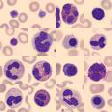

In [12]:
# load the data
blood_train_dataset = Blood_Dataclass(split='train', transform=data_transforms['train'], download=download)
blood_val_dataset = Blood_Dataclass(split='val', transform=data_transforms['test'], download=download)
blood_test_dataset = Blood_Dataclass(split='test', transform=data_transforms['test'], download=download)
print(blood_test_dataset.info)

# encapsulate data into dataloader form
blood_train_loader = data.DataLoader(dataset=blood_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
blood_val_loader = data.DataLoader(dataset=blood_val_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
blood_test_loader = data.DataLoader(dataset=blood_test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

print("Δείγμα εικόνων του Blood Cell Microscope dataset:")
blood_train_dataset.montage(length=4)

In [13]:
#Κάνω ενα instance ίδιο με το trained μοντέλο για να μπορέσω να φορτώσω το state dictionary
blood_model = Net(in_channels=blood_channels, num_classes=9)

#Φορτώνoυμε τις παραμέτρους του trained μοντέλου
blood_model.load_state_dict(best_model.state_dict())

for param in blood_model.parameters():
    #Παγώνουμε τα weights
    blood_model.requires_grad = False


#Αλλάζουμε τα outputs του μοντέλου ωστε να αντιστοιχεί στο καινούργιο dataset
blood_model.fc = nn.Sequential(
            
            nn.Linear(576, 1024),
            nn.Linear(1024, blood_classes))
blood_model = blood_model.to(device)







optimizer_blood = optim.SGD(blood_model.fc.parameters(), lr=learning_rate, momentum=0.9)
scheduler_blood = lr_scheduler.StepLR(optimizer_blood, step_size=2, gamma=0.5)
bl = train_loop(blood_train_loader,blood_val_loader,blood_test_loader,loss_criterion,blood_model,optimizer_blood,scheduler_blood)


Training for  9  Epochs


100%|██████████| 94/94 [00:04<00:00, 21.87it/s]


*************************
Epoch: 1 Training Loss: 0.5951533468905836
Testing training dataset.Accuracy score: 0.8324274604900075
Testing validation dataset.Accuracy score: 0.8247663551401869


100%|██████████| 94/94 [00:04<00:00, 22.07it/s]


*************************
Epoch: 2 Training Loss: 0.3394556746352464
Testing training dataset.Accuracy score: 0.8554226942052011
Testing validation dataset.Accuracy score: 0.8522196261682243


100%|██████████| 94/94 [00:04<00:00, 22.84it/s]


*************************
Epoch: 3 Training Loss: 0.2978624487295747
Testing training dataset.Accuracy score: 0.8663767873568025
Testing validation dataset.Accuracy score: 0.8627336448598131


100%|██████████| 94/94 [00:04<00:00, 22.38it/s]


*************************
Epoch: 4 Training Loss: 0.28114289906807244
Testing training dataset.Accuracy score: 0.8739861192407392
Testing validation dataset.Accuracy score: 0.8685747663551402


100%|██████████| 94/94 [00:04<00:00, 19.69it/s]


*************************
Epoch: 5 Training Loss: 0.27279234398156404
Testing training dataset.Accuracy score: 0.8733171669872063
Testing validation dataset.Accuracy score: 0.8714953271028038


100%|██████████| 94/94 [00:04<00:00, 22.27it/s]


*************************
Epoch: 6 Training Loss: 0.26820437400601804
Testing training dataset.Accuracy score: 0.8788360230788528
Testing validation dataset.Accuracy score: 0.8744158878504673


100%|██████████| 94/94 [00:04<00:00, 22.19it/s]


*************************
Epoch: 7 Training Loss: 0.26178141008131206
Testing training dataset.Accuracy score: 0.8798394514591521
Testing validation dataset.Accuracy score: 0.8785046728971962


100%|██████████| 94/94 [00:04<00:00, 22.29it/s]


*************************
Epoch: 8 Training Loss: 0.25746925023850054
Testing training dataset.Accuracy score: 0.8802575466176101
Testing validation dataset.Accuracy score: 0.8790887850467289


100%|██████████| 94/94 [00:04<00:00, 22.64it/s]


*************************
Epoch: 9 Training Loss: 0.25665495940484107
Testing training dataset.Accuracy score: 0.8846893552972657
Testing validation dataset.Accuracy score: 0.8773364485981309
Final test in test dataset.Accuracy score: 0.8722595732242034
Training time: 65.03088116645813  seconds


In [14]:
#Κανονικό μοντέλο
blood_model_not_transfer = Net(in_channels=blood_channels, num_classes=blood_classes)

blood_model_not_transfer = blood_model_not_transfer.to(device)


optimizer_blood_not= optim.SGD(blood_model_not_transfer.parameters(), lr=learning_rate, momentum=0.9)
scheduler_blood_not = lr_scheduler.StepLR(optimizer_blood_not, step_size=2, gamma=0.5)
bl = train_loop(blood_train_loader,blood_val_loader,blood_test_loader,loss_criterion,blood_model_not_transfer,optimizer_blood_not,scheduler_blood_not)

Training for  9  Epochs


100%|██████████| 94/94 [00:04<00:00, 22.05it/s]


*************************
Epoch: 1 Training Loss: 0.48119657451752573
Testing training dataset.Accuracy score: 0.8781670708253199
Testing validation dataset.Accuracy score: 0.8796728971962616


100%|██████████| 94/94 [00:04<00:00, 22.54it/s]


*************************
Epoch: 2 Training Loss: 0.2352504446171224
Testing training dataset.Accuracy score: 0.8860272598043315
Testing validation dataset.Accuracy score: 0.8878504672897196


100%|██████████| 94/94 [00:04<00:00, 22.56it/s]


*************************
Epoch: 3 Training Loss: 0.17458677774993703
Testing training dataset.Accuracy score: 0.9361986788192993
Testing validation dataset.Accuracy score: 0.9310747663551402


100%|██████████| 94/94 [00:04<00:00, 22.12it/s]


*************************
Epoch: 4 Training Loss: 0.1437270813039504
Testing training dataset.Accuracy score: 0.9438916297349277
Testing validation dataset.Accuracy score: 0.9345794392523364


100%|██████████| 94/94 [00:04<00:00, 22.07it/s]


*************************
Epoch: 5 Training Loss: 0.11394667901913635
Testing training dataset.Accuracy score: 0.9531733422526967
Testing validation dataset.Accuracy score: 0.9439252336448598


100%|██████████| 94/94 [00:04<00:00, 22.23it/s]


*************************
Epoch: 6 Training Loss: 0.10294372180942446
Testing training dataset.Accuracy score: 0.9595283886612593
Testing validation dataset.Accuracy score: 0.9462616822429907


100%|██████████| 94/94 [00:04<00:00, 22.15it/s]


*************************
Epoch: 7 Training Loss: 0.09397068328689784
Testing training dataset.Accuracy score: 0.9624550547704658
Testing validation dataset.Accuracy score: 0.947429906542056


100%|██████████| 94/94 [00:04<00:00, 22.57it/s]


*************************
Epoch: 8 Training Loss: 0.0885889693745412
Testing training dataset.Accuracy score: 0.9612007692950916
Testing validation dataset.Accuracy score: 0.9462616822429907


100%|██████████| 94/94 [00:04<00:00, 22.75it/s]


*************************
Epoch: 9 Training Loss: 0.0813493947207462
Testing training dataset.Accuracy score: 0.9677230537670374
Testing validation dataset.Accuracy score: 0.9544392523364486
Final test in test dataset.Accuracy score: 0.9482607424729611
Training time: 64.53404021263123  seconds


**Τα μοντέλα φαίνεται να μαθαίνουν με το πέρασμα των εποχών.Το μοντέλο που εκπαιδεύτηκε με transfer learning έχει χαμηλότερα scores σε σχέση με το μοντέλο που εκπαιδεύτηκε χώρις transform learning.Παρόλα αυτά το μοντέλο που εκπαίδευτηκε με transfer learning ίσως είναι πιο ανθεκτικό απέναντι στο overfitting καθώς οι τιμές των scores του training και test set είναι πιο κόντα αποτι στο 2ο μοντέλο που φαίνεται να κάνει overfit **